In [5]:
import numpy as np
from mdwsvm import mdwsvm
from msvm import msvm
from mdwd import mdwd
from vertices_generator import vertices
from metric import within_class_error
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from cross_validation import cross_validation
    

prob = [1/3, 1/2, 2/3] # varying probabilities for class 1
dim = [2, 10, 100, 500, 1000]
err = np.zeros((5,3,3)) # 5-dim, 3 methods, 3 prob
c_list = [2**2, 2**2, 2**2, 2**1, 2**0]

In [6]:
for index in range(3):
    p1 = prob[index]    # prob of class 1
    p2 = (1 - p1) / 2   # prob of class 2,3
    size = 300   # size of training data set
    size1 = int(300 * p1)    # size of class 1
    size2 = int(300 * p2)    # size of class 2,3
    sigma = 0.55
    
    for j in range(5):
        d = dim[j]
         
        # Define the centers of the three groups on the unit ball
        u1 = np.concatenate(([1], np.zeros(d-1)))
        u2 = np.concatenate(([-1/2], [np.sqrt(3)/2], np.zeros(d-2)))
        u3 = np.concatenate(([-1/2], [-np.sqrt(3)/2], np.zeros(d-2)))
        
        # Generate the dataset
        X_train = np.zeros((d, size))  # d-dim training dataset, each column is an obervation
        y_train = np.zeros(size, dtype=int)    # labels for training data
        X_test = np.zeros((d, 10 * size)) # d-dim test data
        y_test = np.zeros(10 * size, dtype=int) # labels for test data
        
        # Generate training dataset class1
        for i in range(size1):
            # Class1
            X_train[:, i] = np.random.normal(u1, sigma, size = d)
            y_train[i] = 0
        
        # Generate training dataset class2 and class3
        for i in range(size2):
            # Class2
            X_train[:, i + size1] = np.random.normal(u2, sigma, size = d)
            y_train[i + size1] = 1
            
            # Class3
            X_train[:, i + size1 + size2] = np.random.normal(u3, sigma, size = d)
            y_train[i + size1 + size2] = 2


        # Generate testing dataset class1
        for i in range(10 * size1):
            # Class1
            X_test[:, i] = np.random.normal(u1, sigma, size = d)
            y_test[i] = 0
        
        # Generate testing dataset class2 and class3
        for i in range(10 * size2):
            # Class2
            X_test[:, i + 10 * size1] = np.random.normal(u2, sigma, size = d)
            y_test[i + 10 * size1] = 1
            
            # Class3
            X_test[:, i + 10 * (size1 + size2)] = np.random.normal(u3, sigma, size = d)
            y_test[i + 10 * (size1 + size2)] = 2

        # Shuffle the data
        X_train, y_train = shuffle(X_train.T, y_train, random_state=42)
        X_train = X_train.T
        
        
        # Use cross validation to choose C for MDWSVM based on X_train
        # Define values for cross_validation
        c_values = [2**i for i in range(-3,13)]
        w = vertices(3)
        
        # MDWSVM
        c = c_list[j]
        method = mdwsvm(X_train, y_train, w, c)
        pred_y = method.predict(X_test)
        err[j,0,index] = within_class_error(y_ture = y_test, y_pred = pred_y)
        print(err[j,0,index])
        # msvm
        method = msvm(X_train, y_train, w, c)
        pred_y = method.predict(X_test)
        err[j,1,index] = within_class_error(y_ture = y_test, y_pred = pred_y)

        # mdwd
        method = mdwd(X_train, y_train, w, c)
        pred_y = method.predict(X_test)
        err[j,2,index] = within_class_error(y_ture = y_test, y_pred = pred_y)

0.09433333333333334
0.111
0.14933333333333332
0.257
0.2956666666666667
0.11822222222222223
0.11599999999999999
0.1777777777777778
0.28644444444444445
0.3853333333333333


C:\Users\24232\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\cvxpy\problems\problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


0.154
0.13566666666666669
0.2165
0.437
0.5616666666666666


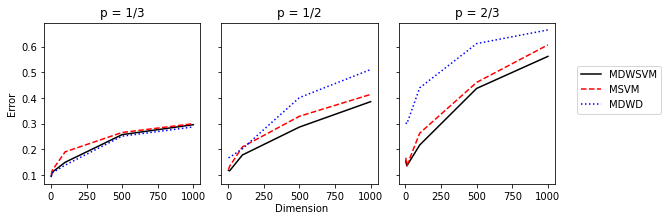

In [41]:
# Plot

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(8, 3))
fig.text(0.53, 0, 'Dimension', ha='center')

axs[0].set_ylabel('Error')
axs[0].set_title('p = 1/3')
axs[0].plot(dim, err[:,0,0], color = 'black', linestyle = '-', label = 'MDWSVM')
axs[0].plot(dim, err[:,1,0], color = 'red', linestyle = '--', label = 'MSVM')
axs[0].plot(dim, err[:,2,0], color = 'blue', linestyle = ':', label = 'MDWD')

axs[1].set_title('p = 1/2')
axs[1].plot(dim, err[:,0,1], color = 'black', linestyle = '-', label = 'MDWSVM')
axs[1].plot(dim, err[:,1,1], color = 'red', linestyle = '--', label = 'MSVM')
axs[1].plot(dim, err[:,2,1], color = 'blue', linestyle = ':', label = 'MDWD')

axs[2].set_title('p = 2/3')
axs[2].plot(dim, err[:,0,2], color = 'black', linestyle = '-', label = 'MDWSVM')
axs[2].plot(dim, err[:,1,2], color = 'red', linestyle = '--', label = 'MSVM')
axs[2].plot(dim, err[:,2,2], color = 'blue', linestyle = ':', label = 'MDWD')

# Create a single legend outside of the subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.0, 0.7))

plt.tight_layout()
plt.show()